In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from glob import iglob

In [2]:
dfs = []

# Read all files into dataframes
for f in iglob('data/raw/' + '*.csv'):
    temp_df = pd.read_csv(f, skiprows=[0], low_memory=False)
    dfs.append(temp_df)

In [3]:
# Get the columns that are consistent in all years
dropped_cols = []
cols = list(dfs[0].columns)
for i in range(1,len(dfs)):
    column_difference = set(cols).difference(set(dfs[i].columns))
    for c in column_difference:
        cols.remove(c)
        dropped_cols.append(c)

In [4]:
dropped_cols

['hardship_start_date',
 'debt_settlement_flag',
 'hardship_loan_status',
 'hardship_last_payment_amount',
 'debt_settlement_flag_date',
 'hardship_end_date',
 'orig_projected_additional_accrued_interest',
 'settlement_status',
 'payment_plan_start_date',
 'deferral_term',
 'open_act_il',
 'hardship_status',
 'hardship_amount',
 'hardship_reason',
 'hardship_payoff_balance_amount',
 'settlement_amount',
 'settlement_term',
 'sec_app_open_act_il',
 'hardship_dpd',
 'settlement_date',
 'hardship_type',
 'disbursement_method',
 'hardship_length',
 'hardship_flag',
 'settlement_percentage']

In [6]:
data = dfs[0][cols]
for i in range(1, len(dfs)):
    data = data.append(dfs[i][cols])

data = data.reset_index(drop=True)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,145217616,NaN,10000,10000,10000.0,36 months,10.33%,324.23,B,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,145640422,NaN,2500,2500,2500.0,36 months,13.56%,84.92,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,145630143,NaN,12000,12000,12000.0,60 months,13.56%,276.49,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,145127870,NaN,15000,15000,14975.0,60 months,14.47%,352.69,C,C2,...,664.0,Oct-99,0.0,0.0,16.0,48.8,15.0,0.0,0.0,NaN
4,145558466,NaN,16000,16000,16000.0,60 months,17.97%,406.04,D,D1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854467,89885898,NaN,24000,24000,24000.0,60 months,12.79%,543.50,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2854468,88977788,NaN,24000,24000,24000.0,60 months,10.49%,515.74,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2854469,88985880,NaN,40000,40000,40000.0,60 months,10.49%,859.56,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2854470,88224441,NaN,24000,24000,24000.0,60 months,14.49%,564.56,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# data for 2015: 128 columns
data = pd.read_csv('data/raw/LoanStats3d_securev1.csv',skiprows=[0], low_memory=False)

In [3]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_il_6m,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,68407277,NaN,3600,3600,3600.0,36 months,13.99%,123.03,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,66310712,NaN,35000,35000,35000.0,60 months,14.85%,829.90,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68566886,NaN,29900,29900,29900.0,60 months,12.88%,678.49,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68495092,NaN,8650,8650,8650.0,36 months,19.89%,320.99,E,E3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68577849,NaN,18000,18000,18000.0,60 months,11.99%,400.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data['loan_status'].value_counts()

Current               2086919
Fully Paid             552459
Charged Off            131231
Late (31-120 days)      32304
In Grace Period         22089
Issued                  21294
Late (16-30 days)        8147
Default                    29
Name: loan_status, dtype: int64

In [8]:
data = data[data['loan_status'].str.lower().isin(['fully paid', 'charged off'])]

In [9]:
data['application_type'].value_counts()

INDIVIDUAL    595373
Individual     77967
Joint App       8214
JOINT           1411
DIRECT_PAY       725
Name: application_type, dtype: int64

In [10]:
data = data[data['application_type'].str.lower()=='individual']

In [11]:
data.shape[0]

673340

In [13]:
# (data['open_il_6m'][data['open_il_6m'].isnull() == False]).sum()

In [14]:
# Columns with missing data

data[data.columns[data.isnull().sum()/data.shape[0] > .2]].isnull().sum()/data.shape[0]

member_id                              1.000000
desc                                   0.864689
mths_since_last_delinq                 0.515172
mths_since_last_record                 0.838423
next_pymnt_d                           1.000000
mths_since_last_major_derog            0.743672
annual_inc_joint                       1.000000
dti_joint                              1.000000
verification_status_joint              1.000000
open_acc_6m                            0.752694
open_il_12m                            0.752693
open_il_24m                            0.752693
mths_since_rcnt_il                     0.758284
total_bal_il                           0.752693
il_util                                0.786271
open_rv_12m                            0.752693
open_rv_24m                            0.752693
max_bal_bc                             0.752693
all_util                               0.752730
inq_fi                                 0.752693
total_cu_tl                            0

In [16]:
drop = ['member_id', 
        'desc', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 
        'revol_bal_joint', 'sec_app_fico_range_low', 
        'sec_app_fico_range_high',
        'sec_app_earliest_cr_line', 
        'sec_app_inq_last_6mths',
        'sec_app_mort_acc', 
        'sec_app_open_acc',
        'sec_app_revol_util',
#         'sec_app_open_il_6m', 
        'sec_app_num_rev_accts',
        'sec_app_chargeoff_within_12_mths',
        'sec_app_collections_12_mths_ex_med',
        'sec_app_mths_since_last_major_derog',
        'funded_amnt_inv', 
        'grade',
        'emp_title', 
        'emp_length',
        'pymnt_plan',
        'url',
        'title',
        'zip_code',
        'addr_state',
        'earliest_cr_line',
        'fico_range_high',
        'initial_list_status',
        'out_prncp',
        'out_prncp_inv',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'recoveries',
        'collection_recovery_fee',
        'last_credit_pull_d', 
        'last_pymnt_d',
        'last_pymnt_amnt',
        'next_pymnt_d',
        'acc_now_delinq',
        'tot_coll_amt',
        'tot_cur_bal',
        'delinq_amnt' 
       ]
data = data.drop(drop, axis=1)

In [17]:
data.purpose.unique()

array(['credit_card', 'debt_consolidation', 'other', 'house',
       'small_business', 'moving', 'home_improvement', 'car', 'vacation',
       'medical', 'major_purchase', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

In [18]:
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [19]:
terms = {' 60 months': 60, ' 36 months': 36}
data['term'] = data['term'].apply(lambda x: terms[x])

In [20]:
def convert_pct(x):
    """
    Converts string with % to a float, handles 'None's.
    """
    if x is None or pd.isnull(x):
        return None
    return float(re.sub('%', '', x))

In [21]:
percent = ['revol_util', 'int_rate']
for p in percent:
    data[p] = data[p].apply(convert_pct)

In [22]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'inq_last_6mths': number of missing values '1' ==> '0.000%'
'mths_since_last_delinq': number of missing values '346886' ==> '51.517%'
'mths_since_last_record': number of missing values '564544' ==> '83.842%'
'revol_util': number of missing values '434' ==> '0.064%'
'mths_since_last_major_derog': number of missing values '500744' ==> '74.367%'
'open_acc_6m': number of missing values '506819' ==> '75.269%'
'open_il_12m': number of missing values '506818' ==> '75.269%'
'open_il_24m': number of missing values '506818' ==> '75.269%'
'mths_since_rcnt_il': number of missing values '510583' ==> '75.828%'
'total_bal_il': number of missing values '506818' ==> '75.269%'
'il_util': number of missing values '529428' ==> '78.627%'
'open_rv_12m': number of missing values '506818' ==> '75.269%'
'open_rv_24m': number of missing values '506818' ==> '75.269%'
'max_bal_bc': number of missing values '506818' ==> '75.269%'
'all_util': number of missing values '506843' ==> '75.273%'
'total_rev_hi_lim': numbe

<AxesSubplot:>

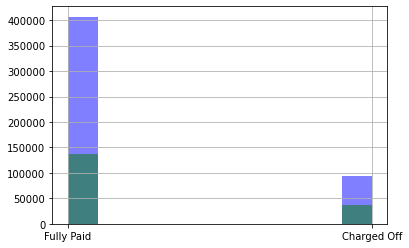

In [23]:
fig, ax = plt.subplots()

data[data['mths_since_last_major_derog'].isna()]['loan_status'].hist(ax = ax, alpha=.5, color='blue')
data[~data['mths_since_last_major_derog'].isna()]['loan_status'].hist(ax = ax, alpha=.5, color='green')

<AxesSubplot:>

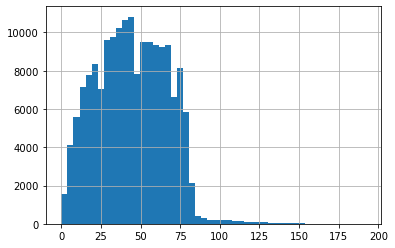

In [24]:
data['mths_since_last_major_derog'].hist(bins = 50)

In [25]:
data['issue_d'].unique()

array(['Dec-18', 'Nov-18', 'Oct-18', 'Dec-13', 'Nov-13', 'Oct-13',
       'Sep-13', 'Aug-13', 'Jul-13', 'Jun-13', 'May-13', 'Apr-13',
       'Mar-13', 'Feb-13', 'Jan-13', 'Dec-12', 'Nov-12', 'Oct-12',
       'Sep-12', 'Aug-12', 'Jul-12', 'Jun-12', 'May-12', 'Apr-12',
       'Mar-12', 'Feb-12', 'Jan-12', 'Dec-14', 'Nov-14', 'Oct-14',
       'Sep-14', 'Aug-14', 'Jul-14', 'Jun-14', 'May-14', 'Apr-14',
       'Mar-14', 'Feb-14', 'Jan-14', 'Dec-15', 'Nov-15', 'Oct-15',
       'Sep-15', 'Aug-15', 'Jul-15', 'Jun-15', 'May-15', 'Apr-15',
       'Mar-15', 'Feb-15', 'Jan-15', 'Jun-18', 'May-18', 'Apr-18',
       'Sep-18', 'Aug-18', 'Jul-18', 'Mar-18', 'Feb-18', 'Jan-18',
       'Jun-20', 'May-20', 'Apr-20', 'Dec-19', 'Nov-19', 'Oct-19',
       '20-Mar', '20-Feb', '20-Jan', 'Mar-19', 'Feb-19', 'Jan-19',
       '19-Jun', '19-May', '19-Apr', '19-Sep', '19-Aug', '19-Jul',
       'Mar-17', 'Feb-17', 'Jan-17', 'Jun-17', 'May-17', 'Apr-17',
       'Sep-17', 'Aug-17', 'Jul-17', 'Dec-17', 'Nov-17', 'Oct-

In [26]:
data[~data['open_acc_6m'].isna()]['issue_d'].unique()

array(['Dec-18', 'Nov-18', 'Oct-18', 'Dec-15', 'Jun-18', 'May-18',
       'Apr-18', 'Sep-18', 'Aug-18', 'Jul-18', 'Mar-18', 'Feb-18',
       'Jan-18', 'Jun-20', 'May-20', 'Apr-20', 'Dec-19', 'Nov-19',
       'Oct-19', '20-Mar', '20-Feb', '20-Jan', 'Mar-19', 'Feb-19',
       'Jan-19', '19-Jun', '19-May', '19-Apr', '19-Sep', '19-Aug',
       '19-Jul', 'Mar-17', 'Feb-17', 'Jan-17', 'Jun-17', 'May-17',
       'Apr-17', 'Sep-17', 'Aug-17', 'Jul-17', 'Dec-17', 'Nov-17',
       'Oct-17', 'Jun-16', 'May-16', 'Apr-16', '16-Sep', '16-Aug',
       '16-Jul', 'Mar-16', 'Feb-16', 'Jan-16', 'Dec-16', 'Nov-16',
       'Oct-16'], dtype=object)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 673340 entries, 126 to 103532
Data columns (total 80 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              673340 non-null  int64  
 1   loan_amnt                       673340 non-null  int64  
 2   funded_amnt                     673340 non-null  int64  
 3   term                            673340 non-null  int64  
 4   int_rate                        673340 non-null  float64
 5   installment                     673340 non-null  float64
 6   sub_grade                       673340 non-null  object 
 7   home_ownership                  673340 non-null  object 
 8   annual_inc                      673340 non-null  float64
 9   verification_status             673340 non-null  object 
 10  issue_d                         673340 non-null  object 
 11  loan_status                     673340 non-null  object 
 12  purpose       

In [29]:
drop = [
#     'last_credit_pull_d', 
    'application_type', 
    'issue_d', 
    'id']
data = data.drop(drop, axis=1)

In [30]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']

In [31]:
X.fillna(value=0.0, inplace=True)

In [32]:
y = y.apply(lambda x: 1 if x=='Charged Off' else 0)

In [33]:
dummies = ['sub_grade', 'verification_status', 'purpose','home_ownership']
X = pd.get_dummies(X, columns=dummies, drop_first=True)

In [34]:
# data['earliest_cr_line'] = data.earliest_cr_line.str.split('-', expand=True)[1]

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [37]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
recall = recall_score(y_test, rf_model.predict(X_test))
precision = precision_score(y_test, rf_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.82068560477265
Precision: 0.8054240990171095


In [38]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
recall = recall_score(y_test, rf_model.predict(X_test))
precision = precision_score(y_test, rf_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.82068560477265
Precision: 0.8054240990171095


In [48]:
recall = recall_score(y_test, gb_model.predict(X_test))
precision = precision_score(y_test, gb_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.8295879570956075
Precision: 0.7997020262216925


In [39]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(left=0,right=1)
    ax.set_ylim(bottom=0,top=1)

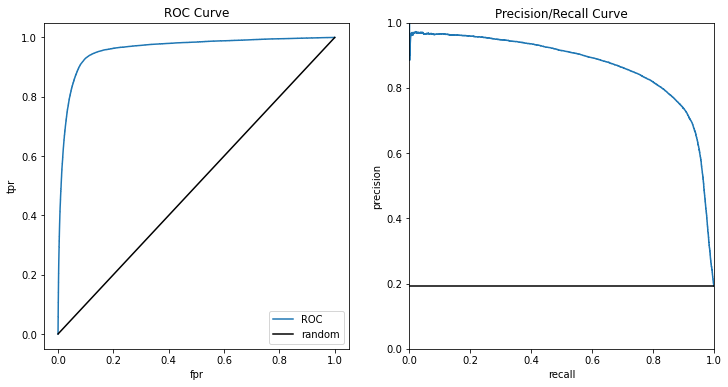

In [59]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
df = calculate_threshold_values(rf_model.predict_proba(X_test)[:,1], y_test)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)

In [65]:
probabilities = rf_model.predict_proba(X_test)

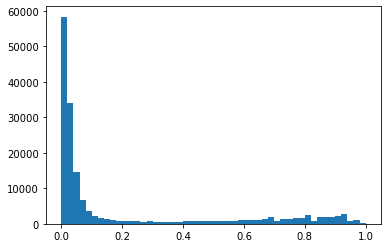

In [69]:
fig, ax = plt.subplots()
ax.hist(probabilities[:,1], bins=50);

In [62]:
(probabilities > .5).sum()

32964

In [63]:
y.sum()

130007

In [64]:
threshold = np.linspace(0,1,50)
yhat = rf_model.predict_proba(X_test)[:,1]

recall = []
precision = []
for t in threshold:
    c = pd.crosstab(pd.Categorical(y_test, categories=[0,1]), 
                    pd.Categorical(yhat>t, categories=[0,1]), 
                    rownames=['actual'], 
                    colnames=['predicted'],
                    dropna=False)
    r = c[1][1]/(c[1][1]+c[0][1])
    p = c[1][1]/(c[1][1]+c[1][0])
    recall.append(r)
    precision.append(p)

<ipython-input-64-6ed33272057a>:13: RuntimeWarning: invalid value encountered in long_scalars
  p = c[1][1]/(c[1][1]+c[1][0])


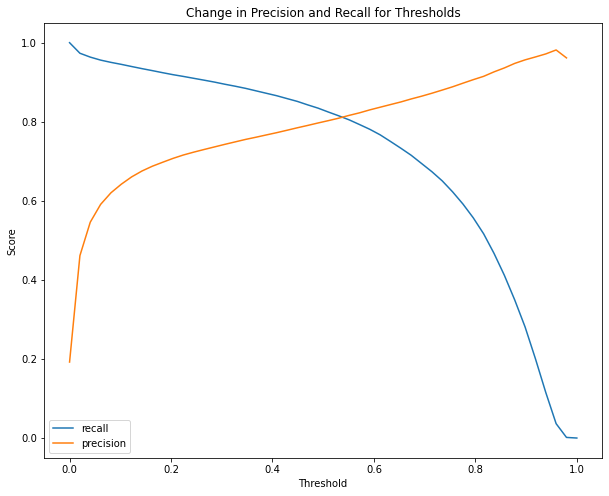

In [58]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(threshold, recall, label='recall')
ax.plot(threshold, precision, label='precision')
# ax.vlines([.08, .85], 0,1, linestyles='--', colors='green')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Change in Precision and Recall for Thresholds')
plt.show()

In [82]:
y_prob = rf_model.predict_proba(X_test)[:,1]

In [99]:
# make predictions based on probabilities and threshold
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 1 is the positive class'''
    return np.where(model.predict_proba(X)[:,1] > threshold, 1, 0)

# create confusion matrix with a given model and Xtest
def confusion_matrix(model, X, y,  threshold=0.5):
    cf = pd.crosstab(y, predict(model, X, threshold), dropna=False)
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=[0, 1], index=[0, 1]), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

# calculate the payout for a given probability threshold
def calculate_payout(cb_matrix, model, X, y, threshold):
    return (confusion_matrix(model, X, y, threshold) * cb_matrix).values.sum()

In [89]:
rf_model.classes_

array([0, 1])

In [92]:
cf = confusion_matrix(rf_model, X_test, y_test)

In [101]:
cf

predicted,0,1
actual,,
0,129570,6414
1,5801,26550


In [96]:
cb_matrix = pd.DataFrame([[0, -20], [0, 10]], columns=[0, 1], index=[0,1])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'

In [97]:
cb_matrix

predicted,0,1
actual,,
0,0,-20
1,0,10


In [ ]:
calculate_payout(cb_matrix, rf_model, X_test, y_test, .5)

In [104]:
-10*6414 + 26550 * 10

201360

In [110]:
def profit_curve(model, X, y, ax):
    cb_matrix = pd.DataFrame([[0, -20], [0, 10]], columns=[0, 1], index=[0,1])
    cb_matrix.index.name = 'actual'
    cb_matrix.columns.name = 'predicted'
    # calculate the payout with a the cost benefit matrix, 
    # given threshhold, model, and X
    thresholds = np.arange(0.0, 1.0, 0.05)
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(cb_matrix, model, X, y, threshold))
    ax.plot(thresholds, profits)
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Profits')
    ax.set_title('Profit Curve')
    print(profits)

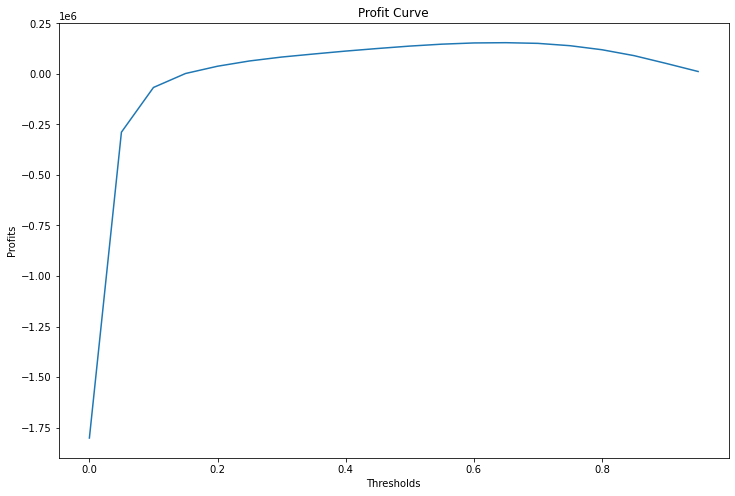

In [111]:
fig, ax = plt.subplots(figsize=(12, 8))
profit_curve(rf_model, X_test, y_test, ax)

In [112]:
y_hat = predict(rf_model, X_test, threshold=.65)

In [114]:
y_test

26825     0
164124    0
35983     0
80212     0
225715    0
         ..
26599     0
118287    0
26991     0
102344    0
37437     0
Name: loan_status, Length: 168335, dtype: int64

In [131]:
y_test.index.values

array([ 26825, 164124,  35983, ...,  26991, 102344,  37437])

In [137]:
data.reset_index(drop=True)

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,4500,4500,36,11.31,147.99,B3,RENT,38500.0,Not Verified,Fully Paid,...,0.0,4.0,91.7,0.0,0,0,53795.0,29137.0,15100.0,24595.0
1,30000,30000,36,15.02,1040.26,C3,RENT,90000.0,Verified,Fully Paid,...,0.0,3.0,100.0,50.0,0,0,89849.0,51370.0,41600.0,36249.0
2,2500,2500,36,13.56,84.92,C1,RENT,42000.0,Not Verified,Fully Paid,...,0.0,1.0,83.3,0.0,0,0,32582.0,18649.0,10500.0,22082.0
3,2000,2000,36,16.91,71.22,C5,MORTGAGE,71000.0,Source Verified,Fully Paid,...,1.0,2.0,86.4,100.0,0,0,208459.0,56421.0,6000.0,84596.0
4,20000,20000,60,17.97,507.55,D1,RENT,57000.0,Not Verified,Fully Paid,...,0.0,2.0,100.0,33.3,0,0,72700.0,33356.0,64800.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673335,5000,5000,36,21.49,189.64,D5,RENT,43000.0,Verified,Fully Paid,...,1.0,0.0,94.1,0.0,0,0,64546.0,60559.0,4000.0,59646.0
673336,32000,32000,60,13.99,744.42,C3,MORTGAGE,125000.0,Source Verified,Charged Off,...,0.0,2.0,97.3,25.0,0,0,557391.0,138125.0,94600.0,124725.0
673337,40000,40000,60,15.59,964.03,C5,MORTGAGE,220000.0,Verified,Fully Paid,...,0.0,3.0,100.0,0.0,0,0,558214.0,73480.0,141000.0,35551.0
673338,15000,15000,36,10.49,487.47,B3,MORTGAGE,60000.0,Not Verified,Fully Paid,...,0.0,2.0,100.0,50.0,0,0,297396.0,48654.0,78700.0,0.0
